# EDA #2 & Feature selection

## Abstract

This notebook aimed at making a second batch of data explorations on the features set against the target variable.

___NB: the evaluation is made on 1/50 of the original data - since originally those features' data is ~ 8 GB.___

In [1]:
import time
import pandas as pd
import pandas_profiling

## Import data

In [2]:
%%bigquery data

SELECT
  *
FROM
  `aliz-ml-spec-2022-dev.mormota.Demo1_MLdataset`
WHERE
  RAND() < 1/200

Downloading: 100%|██████████| 276017/276017 [00:02<00:00, 126927.87rows/s]


In [3]:
data.head()

,trip_id,fare,primary_fare,trip_start_timestamp,TripStartYear,TripStartMonth,TripStartDay,TripStartHour,TripStartMinute,trip_seconds,...,rawLongitude,rawLatitude,historical_tripDuration,histOneWeek_tripDuration,histOneMonth_tripDuration,histThreeMonth_tripDuration,historical_tripDistance,histOneWeek_tripDistance,histOneMonth_tripDistance,histThreeMonth_tripDistance
0,b2e7388775cf36738350440bda4db4fe4b1c8fef,6.00,7.707222,2019-07-24 09:00:00+00:00,2019,7,Wednesday,9,0,347,...,0.014425,0.000019,378.458716,382.250000,398.909091,440.633803,0.970609,0.945000,0.976364,1.259718
1,67ee46e7f76a3ac808892404db00cd3ea7ccdcb9,7.75,9.892778,2019-09-17 09:00:00+00:00,2019,9,Tuesday,9,0,409,...,0.004815,0.011258,558.028462,614.789474,600.150000,480.162791,1.647885,1.525263,1.494000,1.500465
2,db8556a0233bdcdb170a39b5fa6db69002349ed2,6.00,7.751389,2018-05-06 19:00:00+00:00,2018,5,Sunday,19,0,389,...,0.011699,0.009572,460.281690,540.000000,480.000000,465.000000,1.244085,1.300000,1.333333,1.361429
3,be375dda8813071786586ce88bada3654bf6bead,25.25,36.333333,2017-08-02 18:45:00+00:00,2017,8,Wednesday,18,45,2820,...,0.010021,0.072836,1800.000000,NaN,NaN,NaN,5.700000,NaN,NaN,NaN
4,c82e1a8d2a6ba8195467d1e0353676496848d8ad,8.00,11.021389,2016-11-08 08:45:00+00:00,2016,11,Tuesday,8,45,578,...,0.003014,0.026497,740.691318,792.600000,720.800000,798.700000,1.732926,1.640000,1.689500,1.962000


### Comment

The field `primary_fare` has been created out of the original pricing instructions issued by the city of Chicago: https://checkertaxichicago.com/rates-table/.

Such fare should be the minimum possible since diverse fees are not applied (additional passengers, airport tax, etc.)

However we can notice great discrepancies from now on since the applied real fare can actually be lower than the one advised.

## Check the types

In [4]:
data.dtypes

trip_id                                     object
fare                                       float64
primary_fare                               float64
trip_start_timestamp           datetime64[ns, UTC]
TripStartYear                                int64
TripStartMonth                               int64
TripStartDay                                object
TripStartHour                                int64
TripStartMinute                              int64
trip_seconds                                 int64
trip_miles                                 float64
pickup_census_tract                          int64
dropoff_census_tract                         int64
rawDistance                                float64
rawLongitude                               float64
rawLatitude                                float64
historical_tripDuration                    float64
histOneWeek_tripDuration                   float64
histOneMonth_tripDuration                  float64
histThreeMonth_tripDuration    

In [5]:
categorical_variables = [
    'TripStartYear',
    'TripStartMonth',
    'TripStartDay',
    'TripStartHour',
    'TripStartMinute',
    'pickup_census_tract',
    'dropoff_census_tract'
]

date_variables = ['trip_start_timestamp']

numerical_variables = [
    'fare',
    'primary_fare',
    'trip_seconds',
    'trip_miles',
    'rawDistance',
    'rawLongitude',
    'rawLatitude',
    'historical_tripDuration',
    'histOneWeek_tripDuration',
    'histOneMonth_tripDuration',
    'histThreeMonth_tripDuration',
    'historical_tripDistance',
    'histOneWeek_tripDistance',
    'histOneMonth_tripDistance',
    'histThreeMonth_tripDistance'
]

In [6]:
data[categorical_variables] = data[categorical_variables].astype('categorical')

## Sweetviz

                                             |          | [  0%]   00:00 -> (? left)


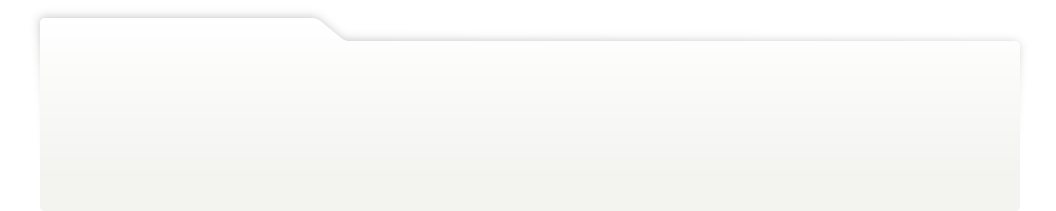
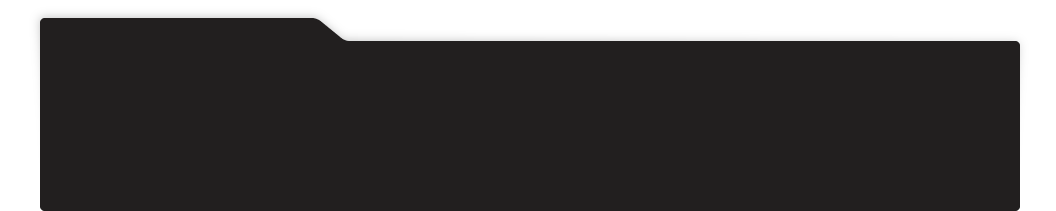
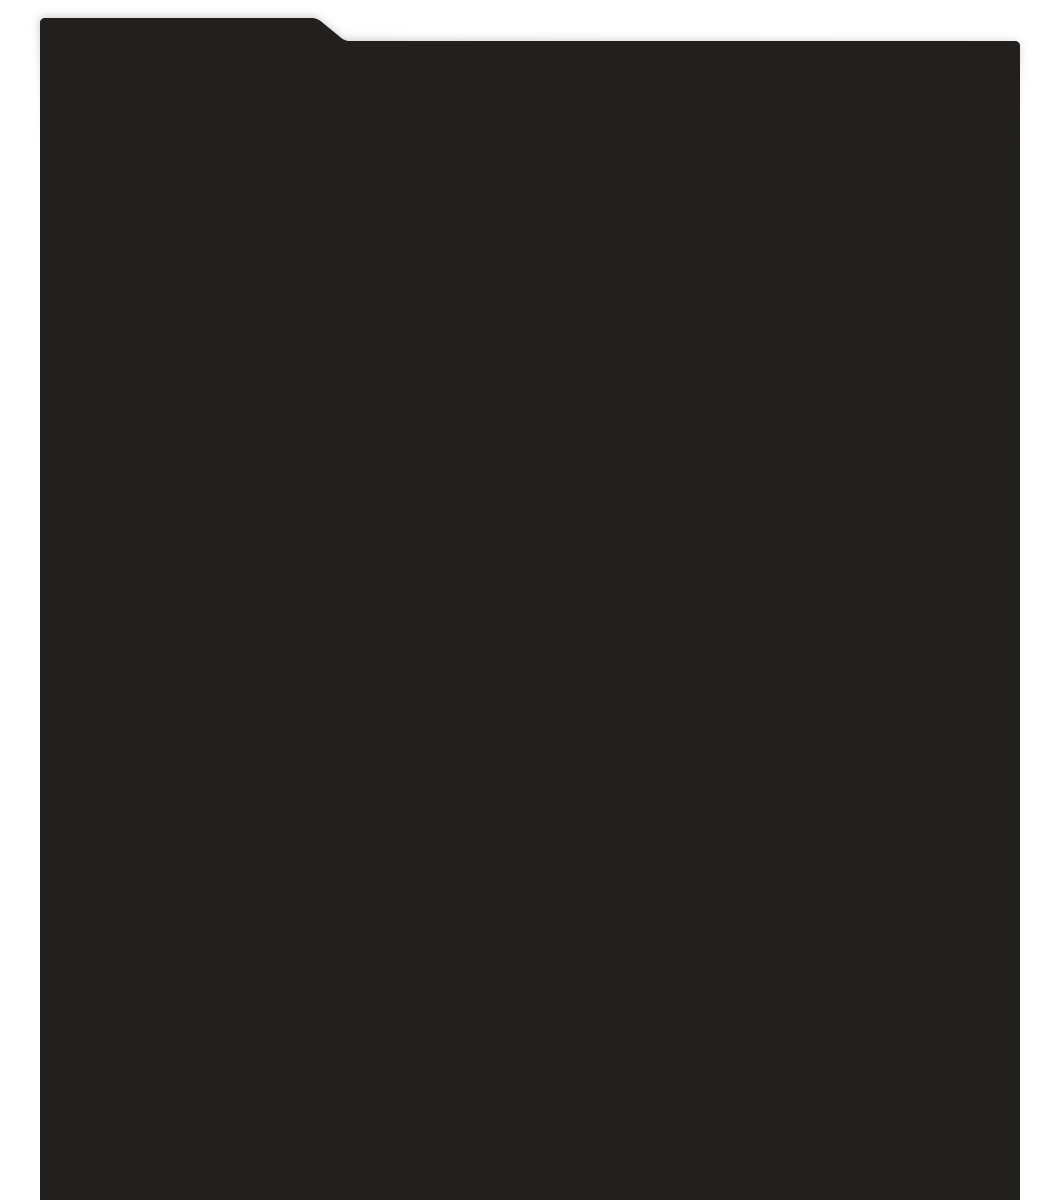
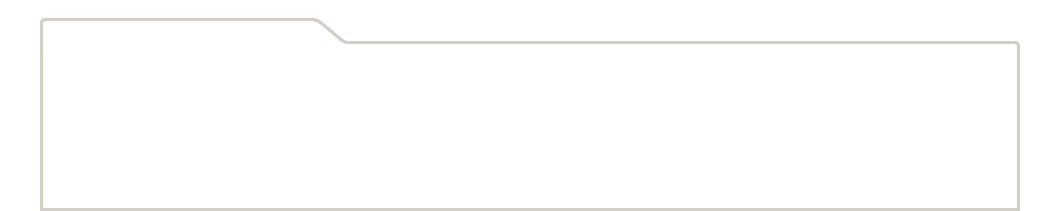
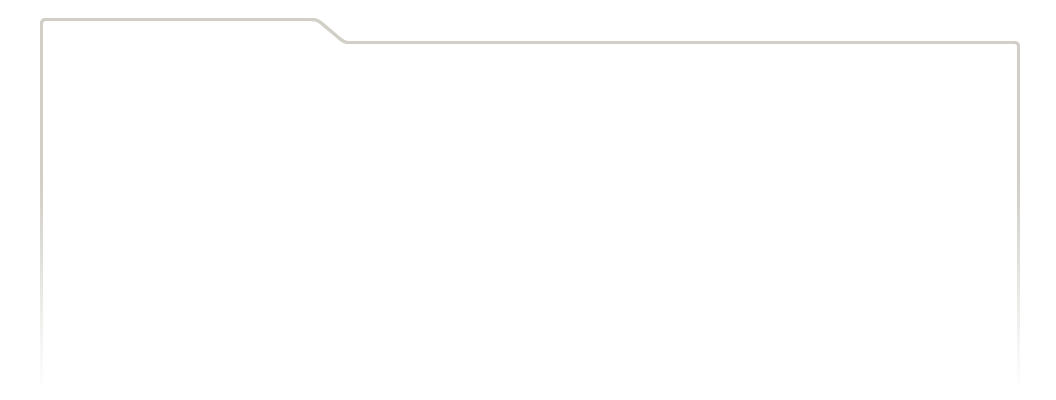
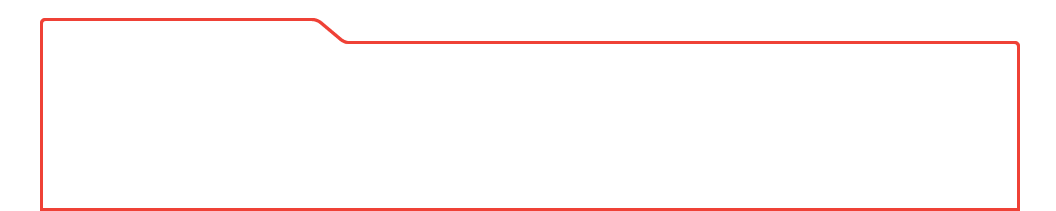
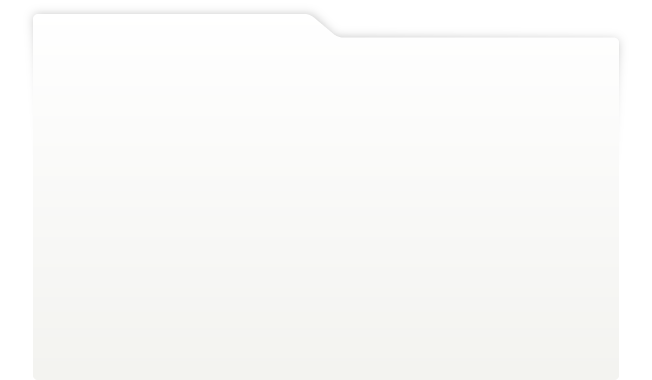
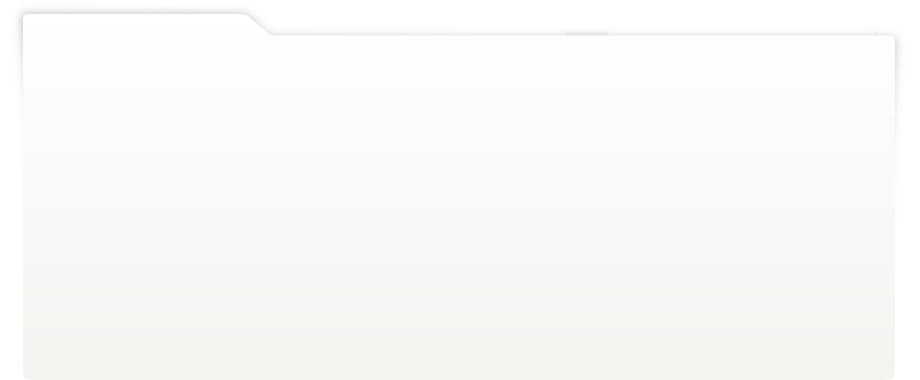
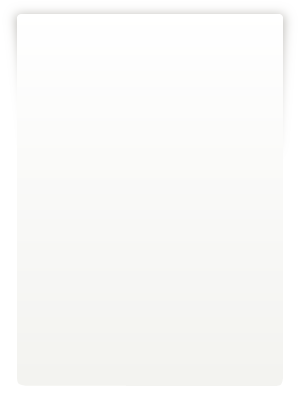
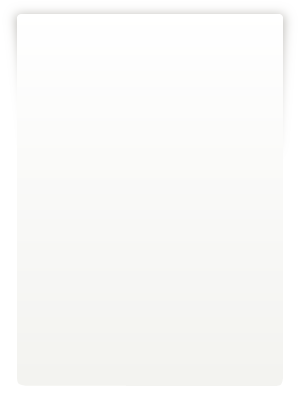
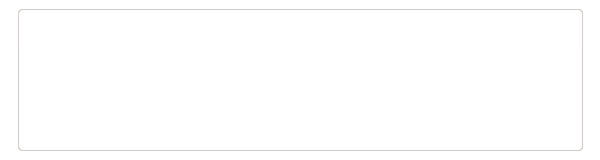
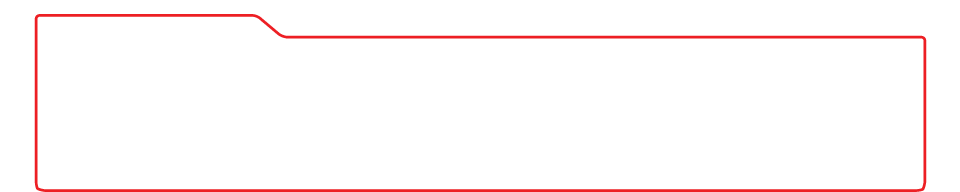
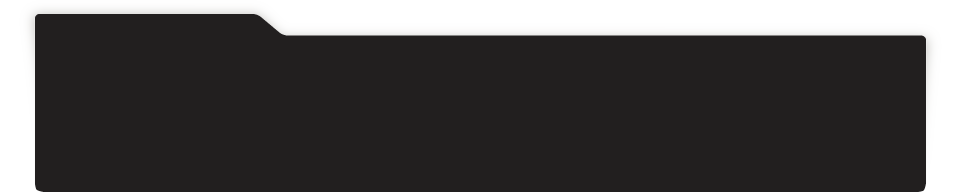
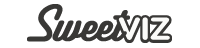
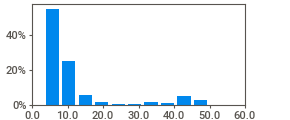
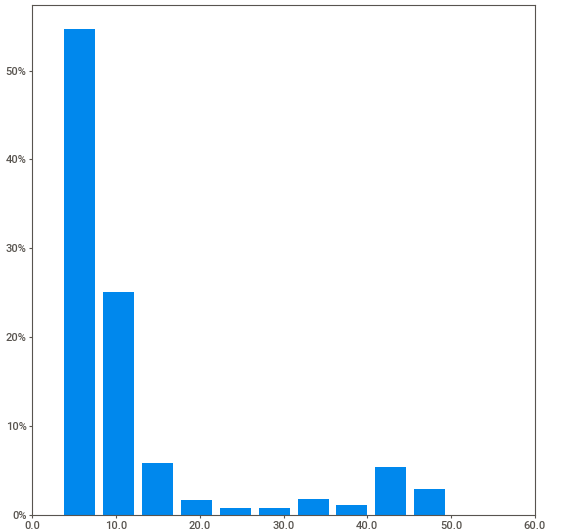
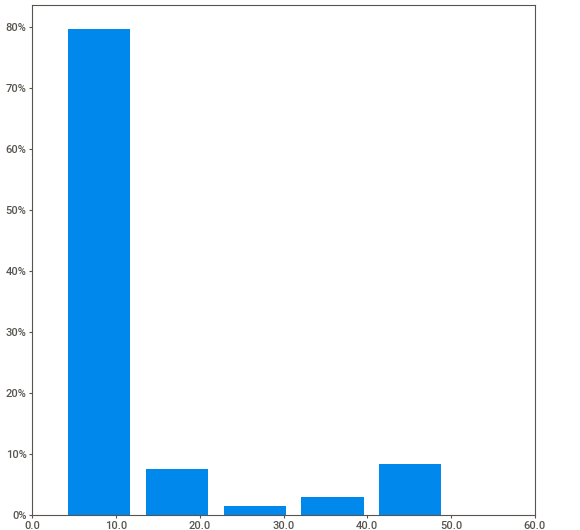
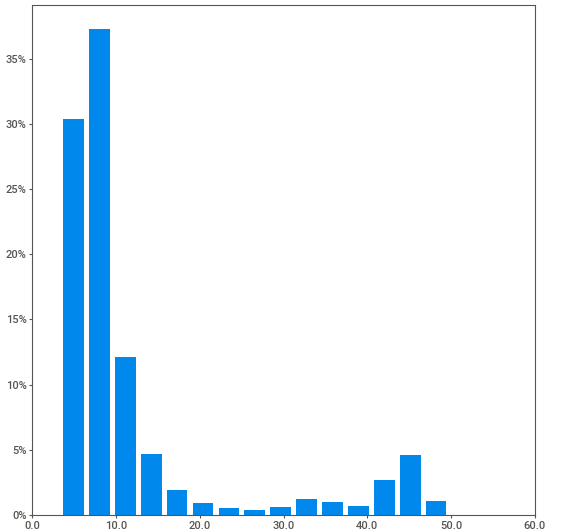
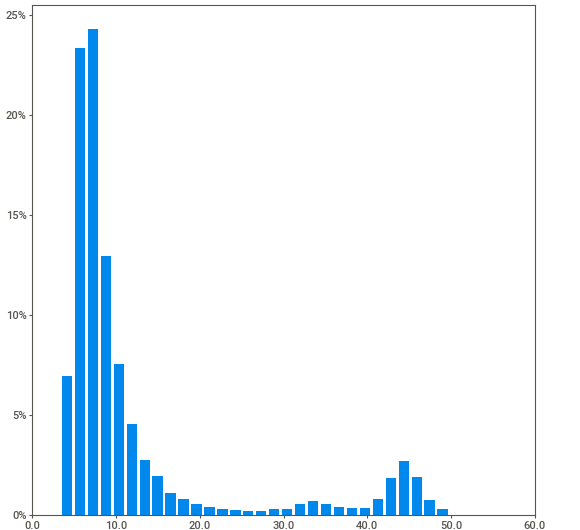
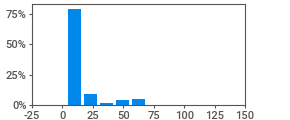
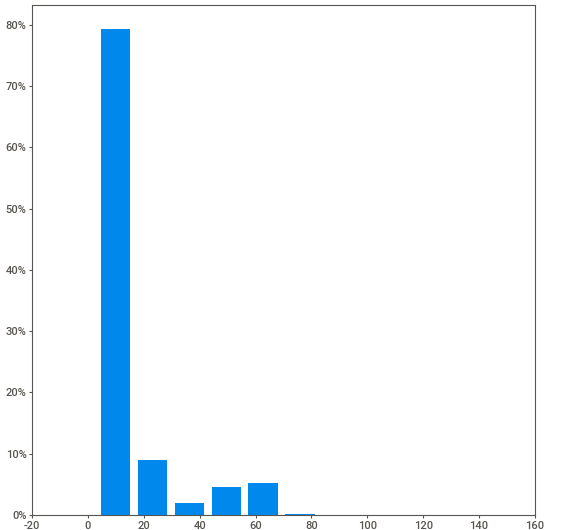
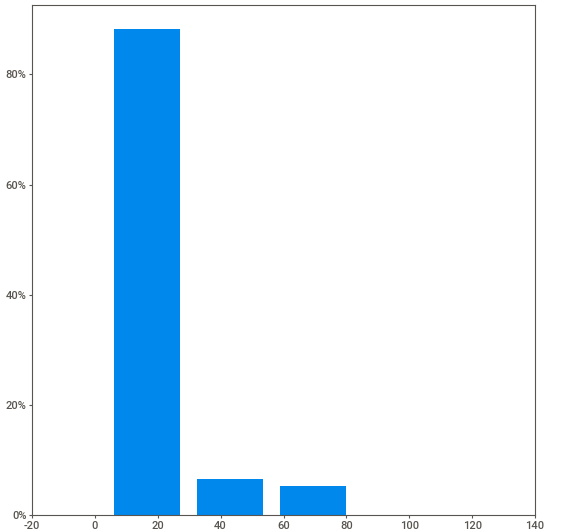
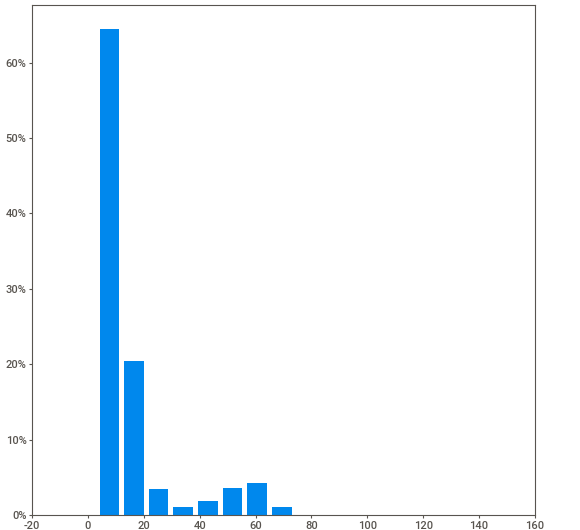
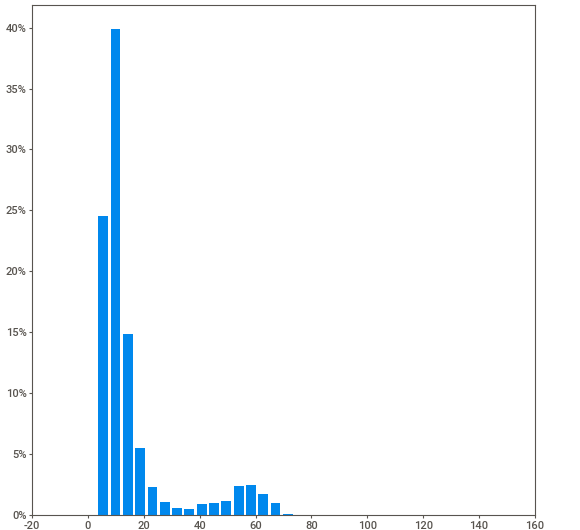
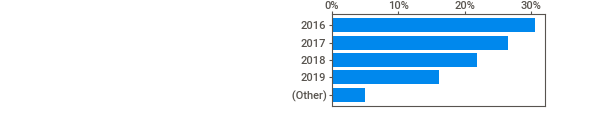
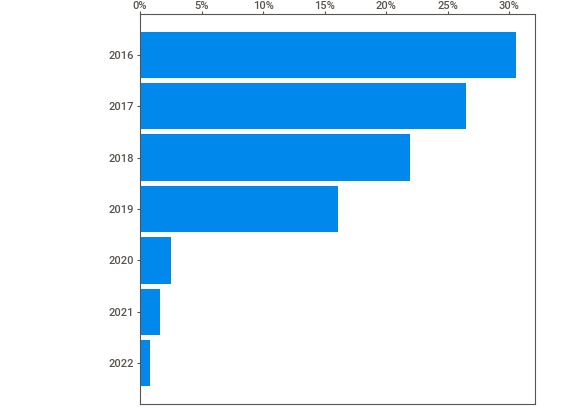
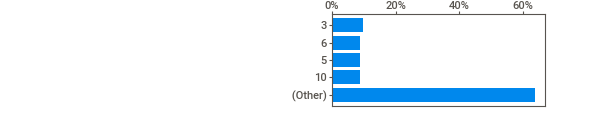
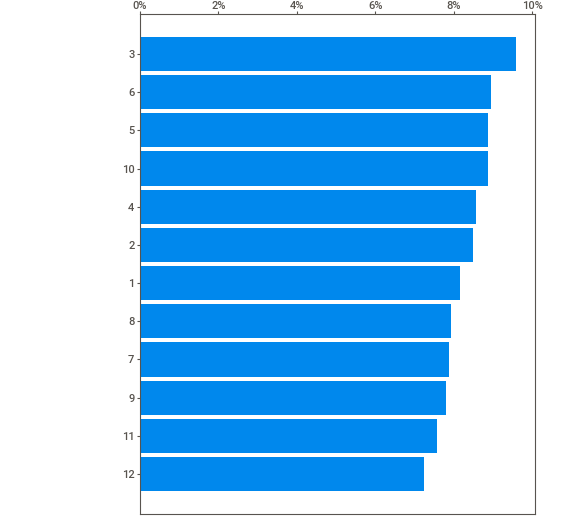
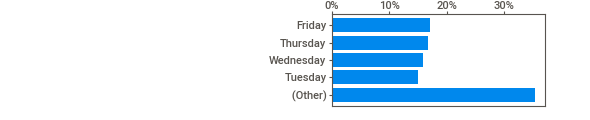
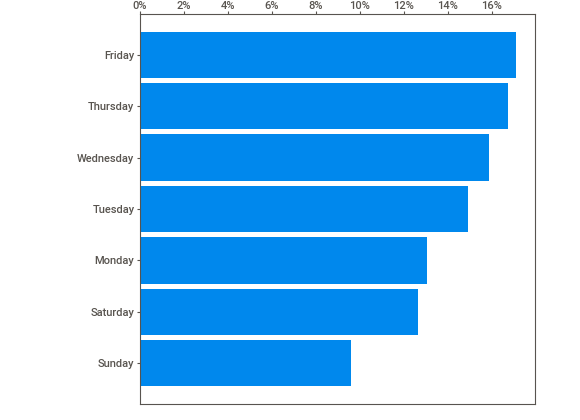
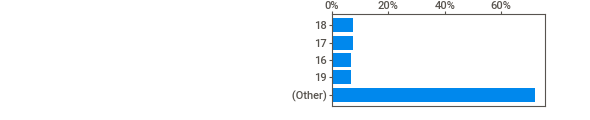
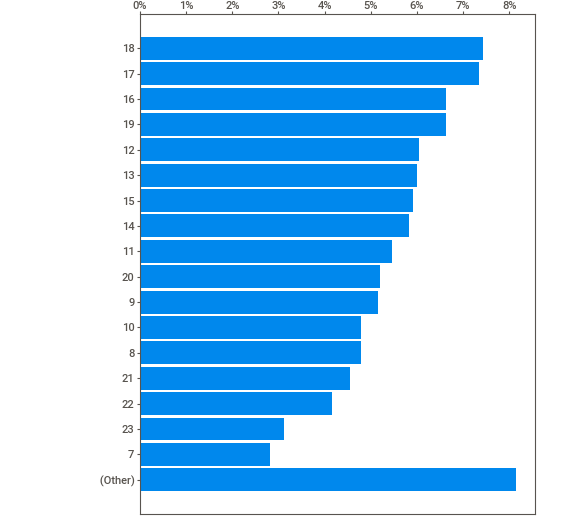
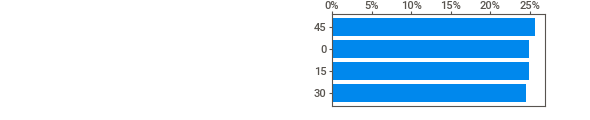
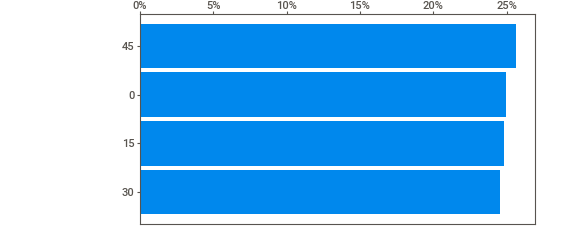
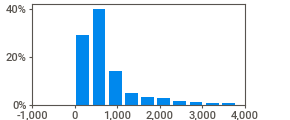
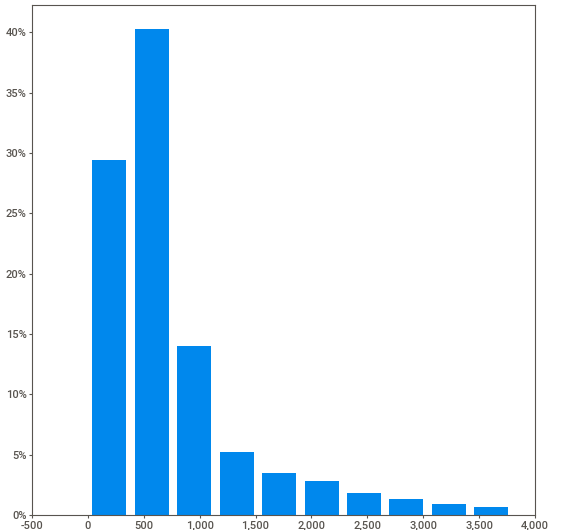
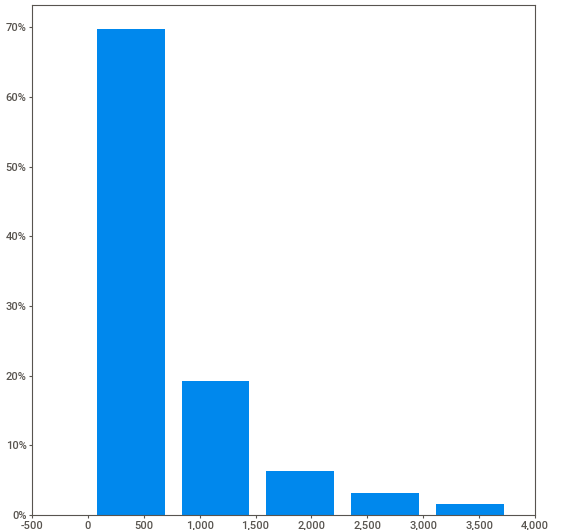
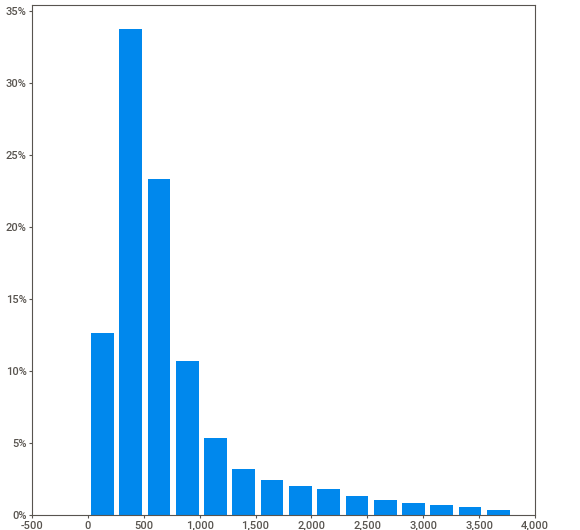
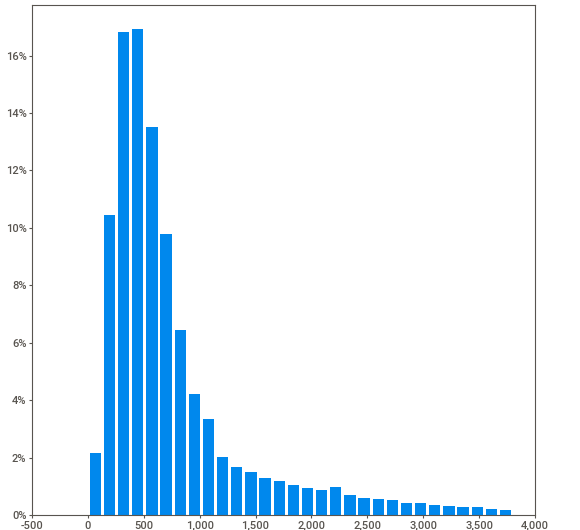
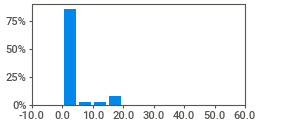
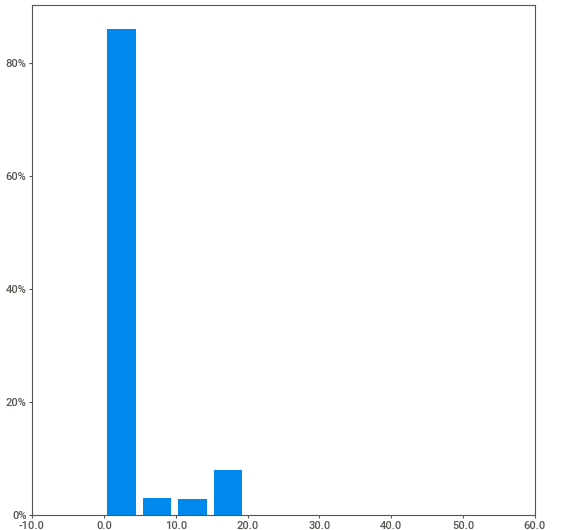
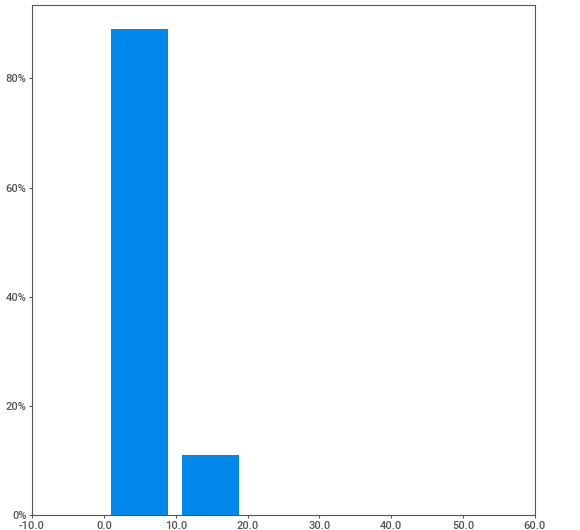
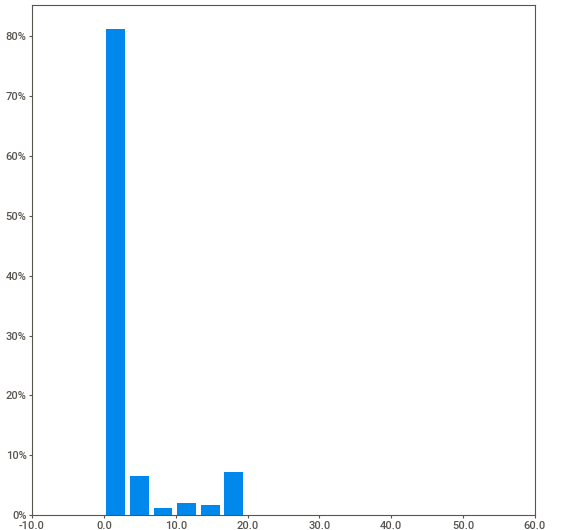
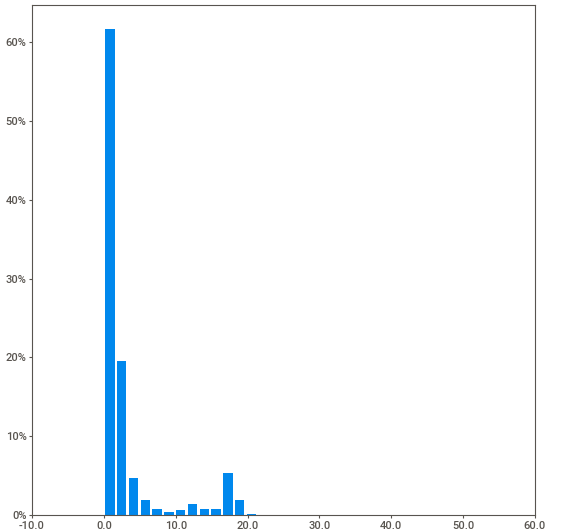
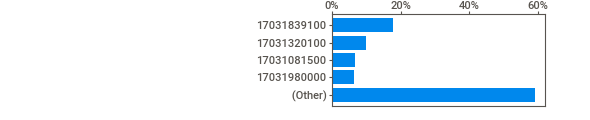
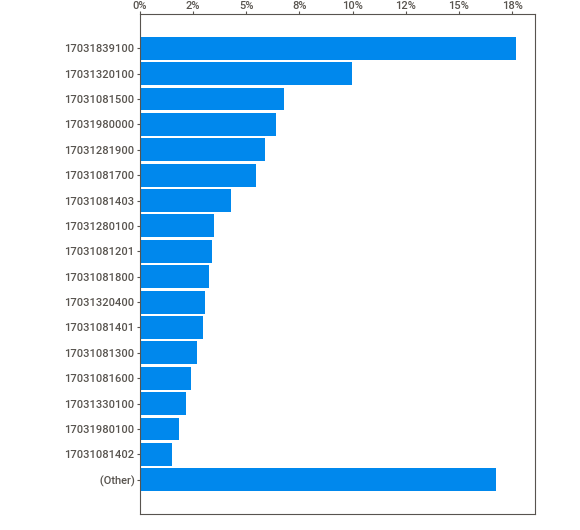
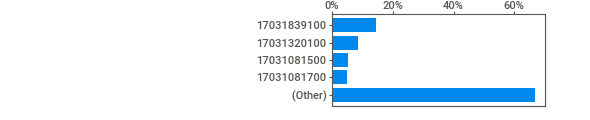
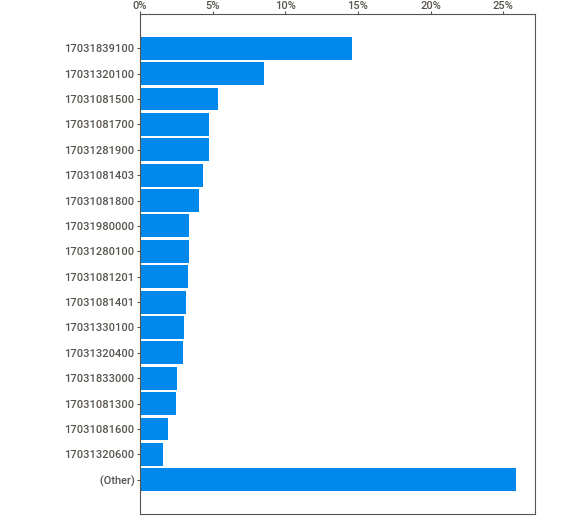
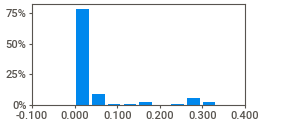
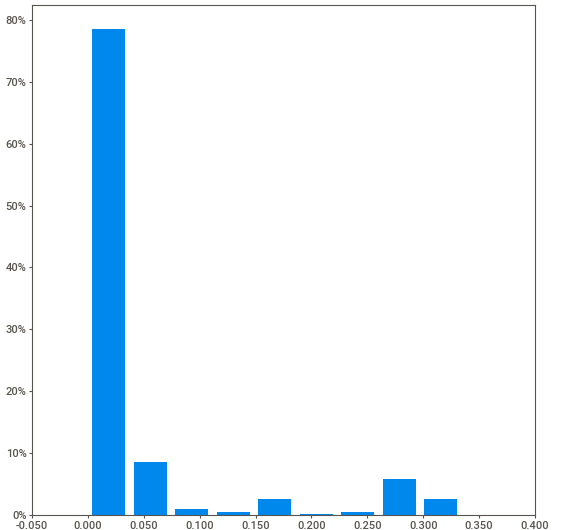
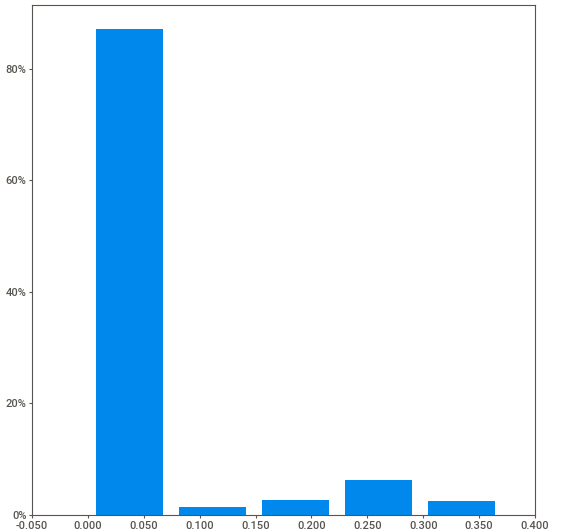
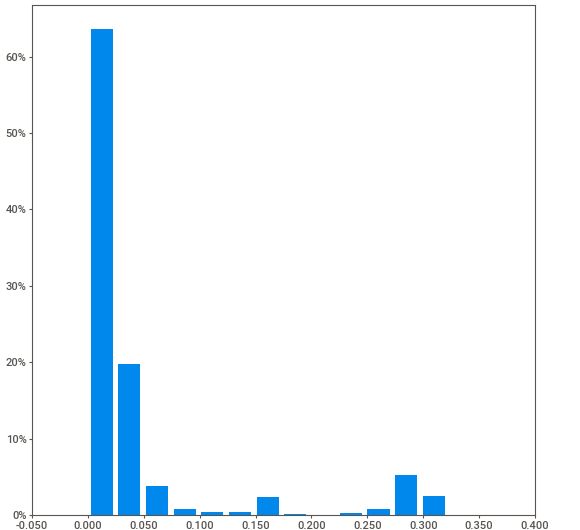
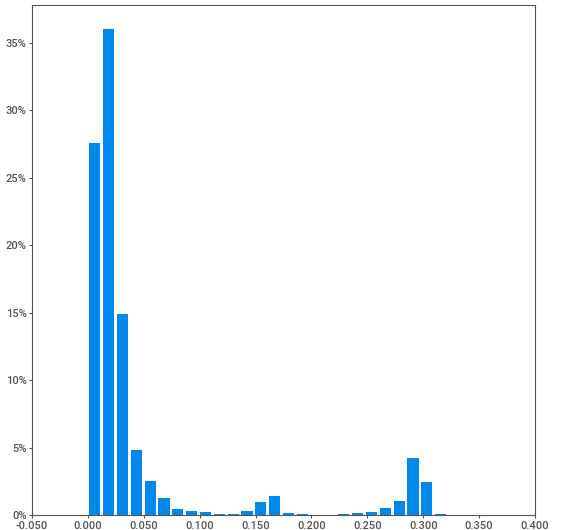
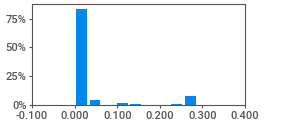
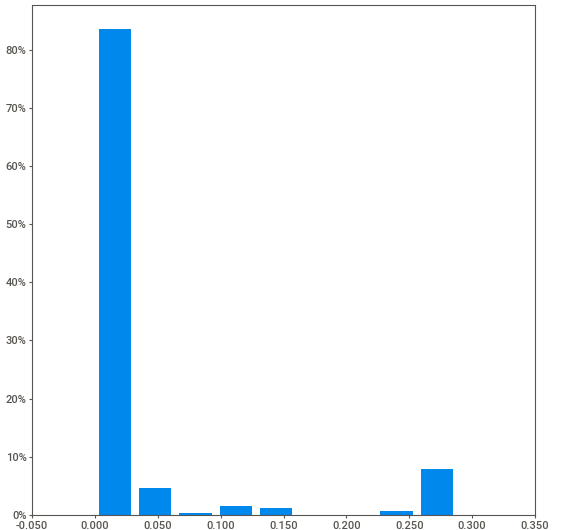
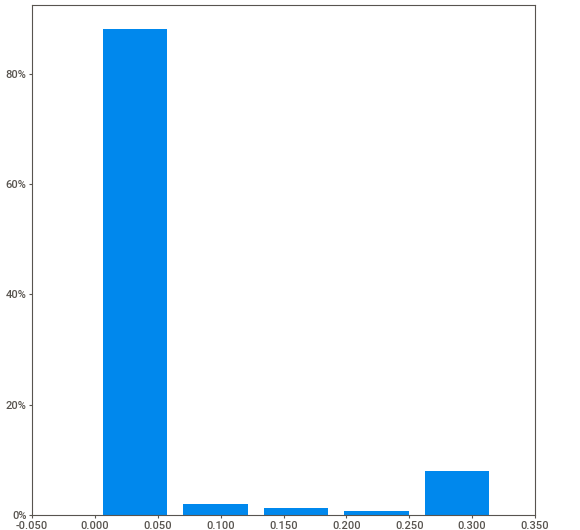
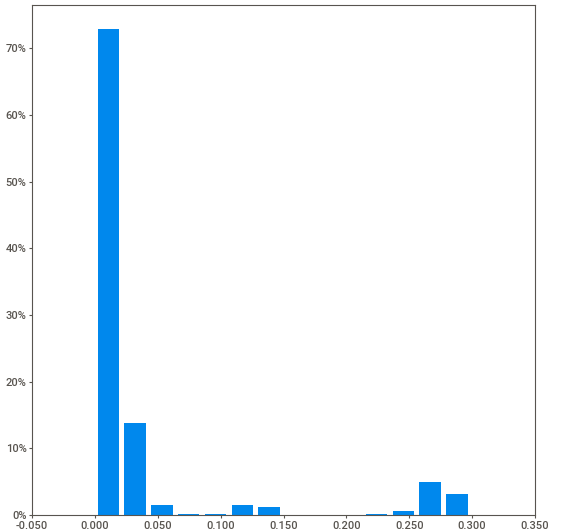
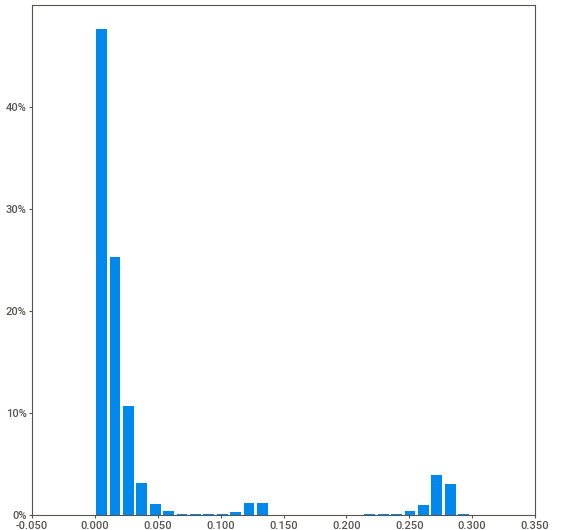
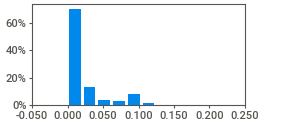
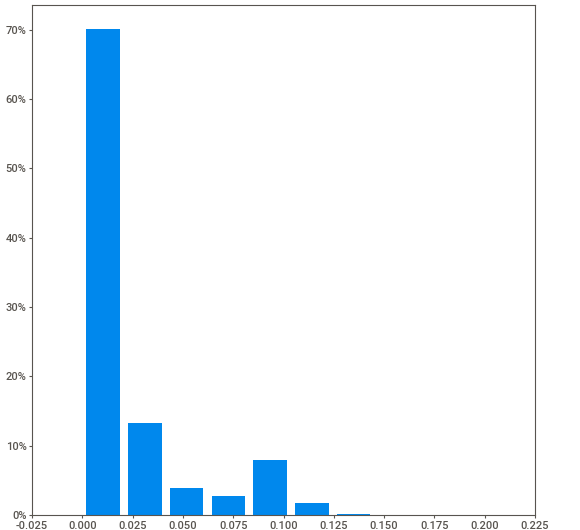
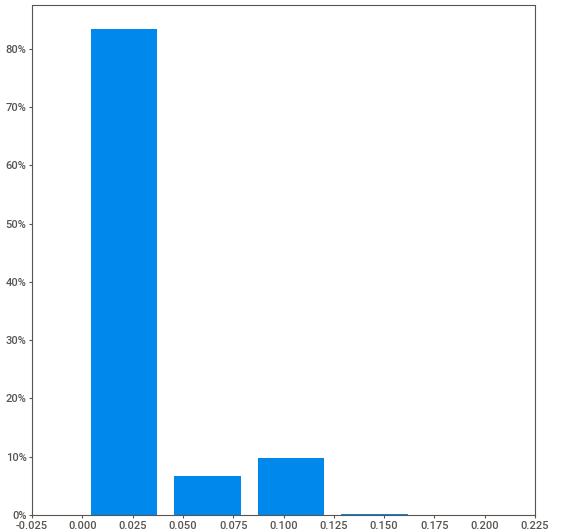
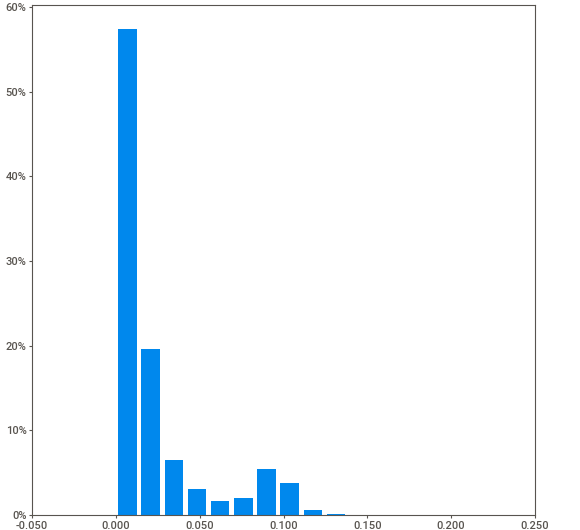
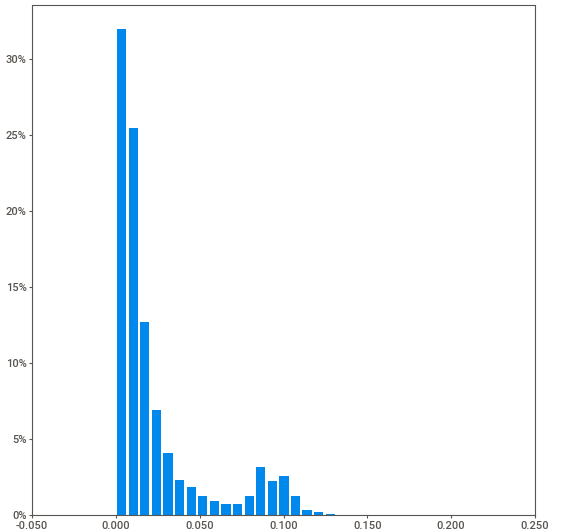
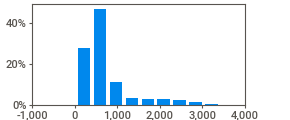
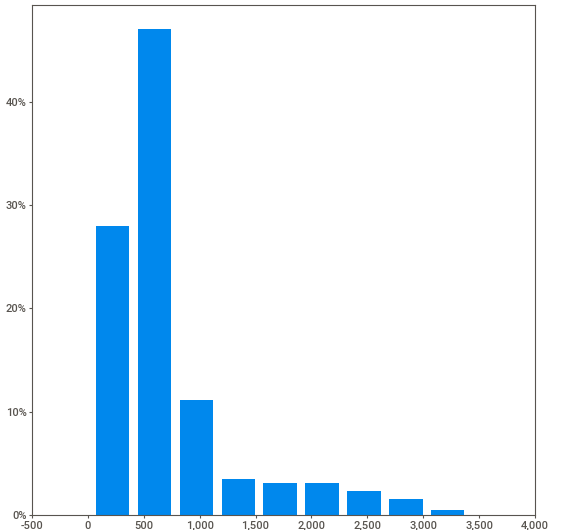
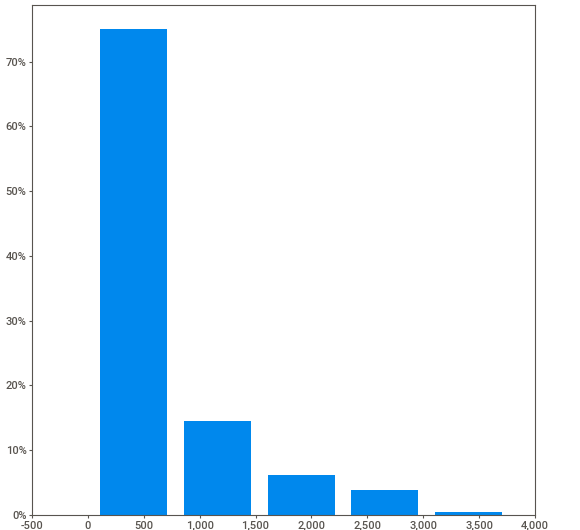
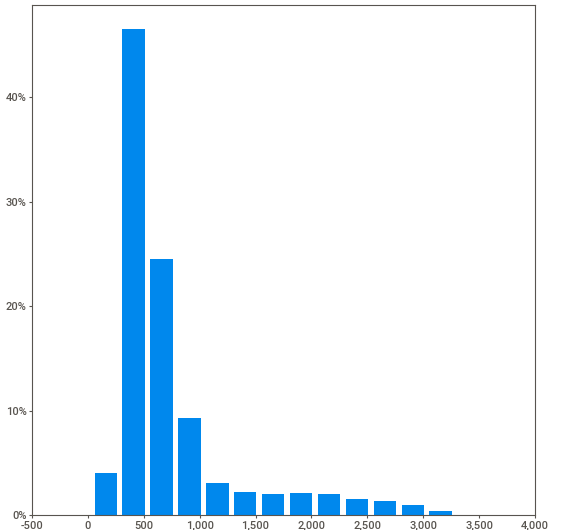
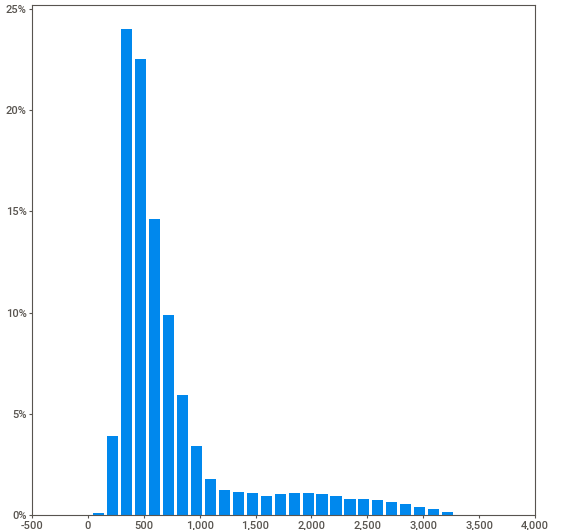
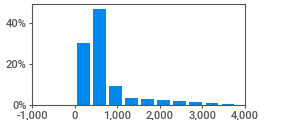
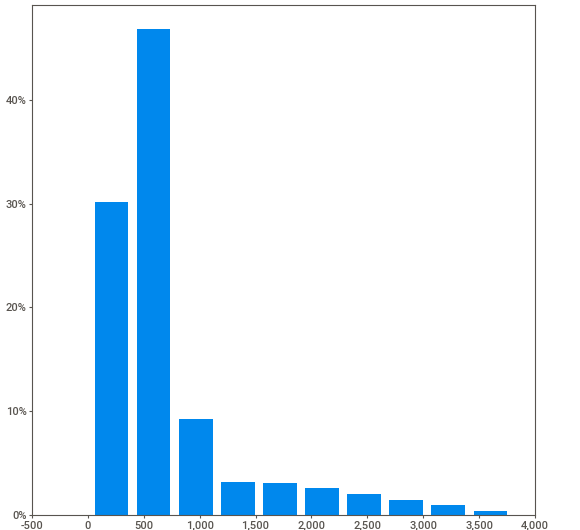
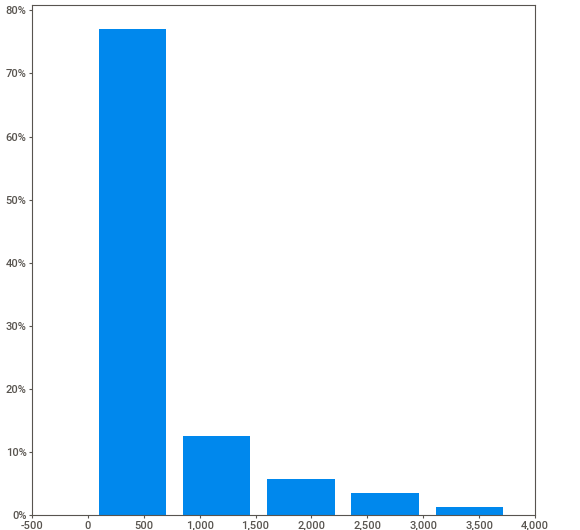
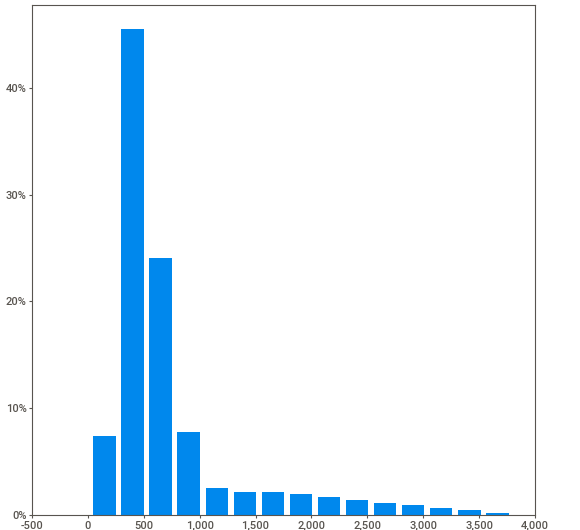
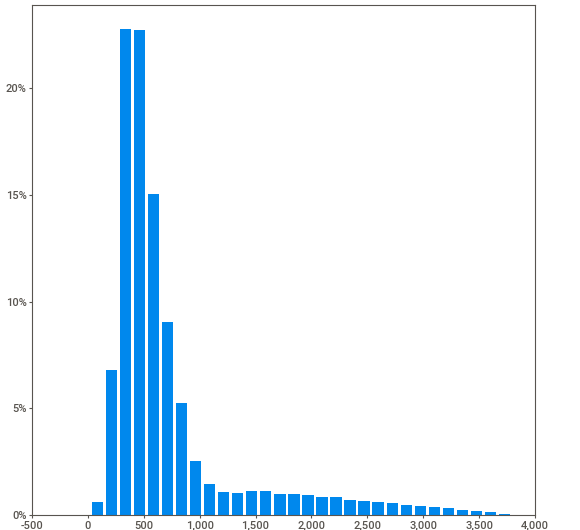
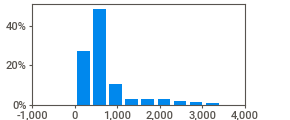
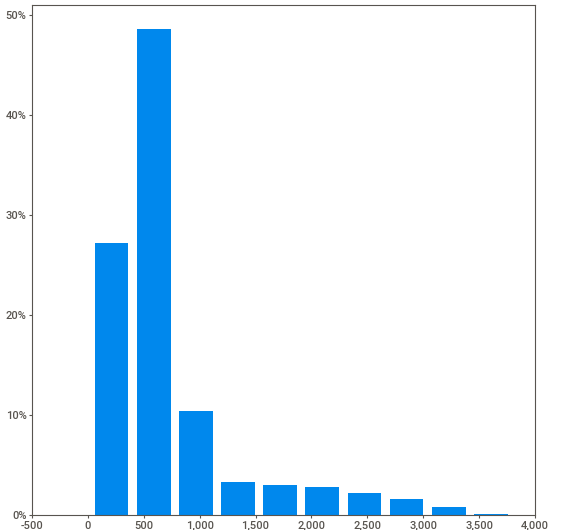
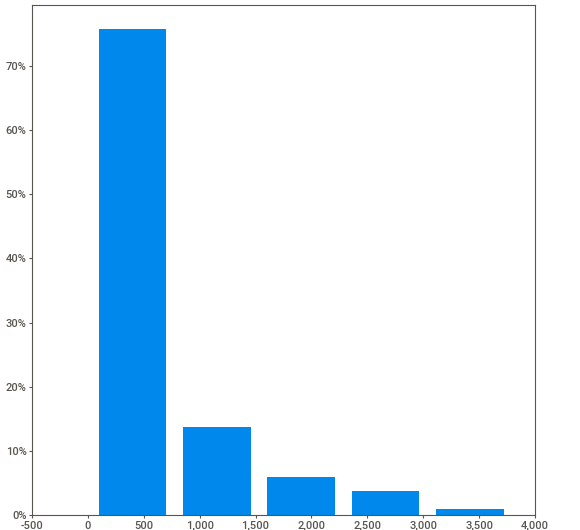
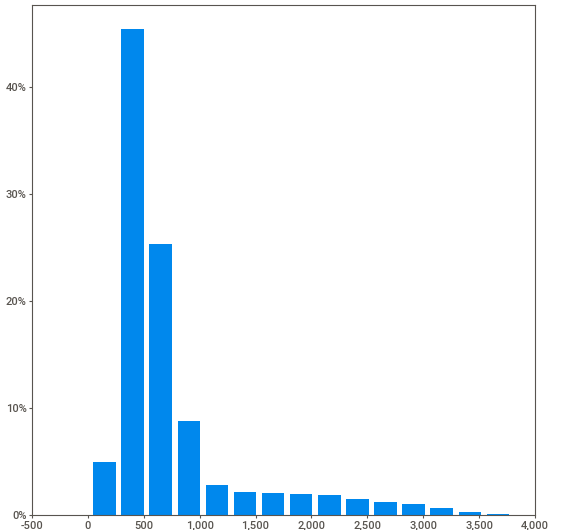
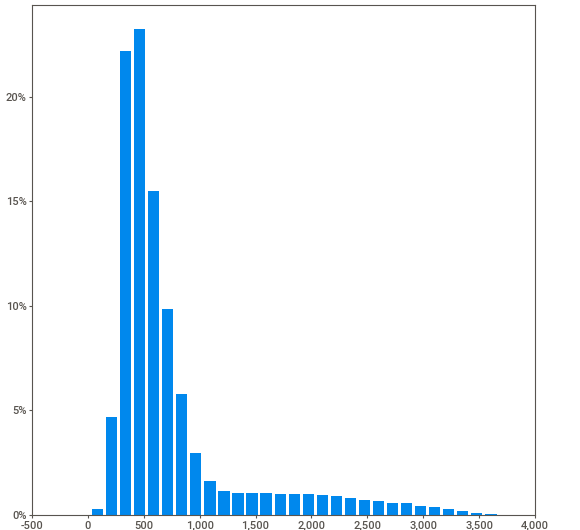
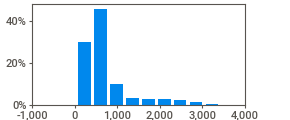
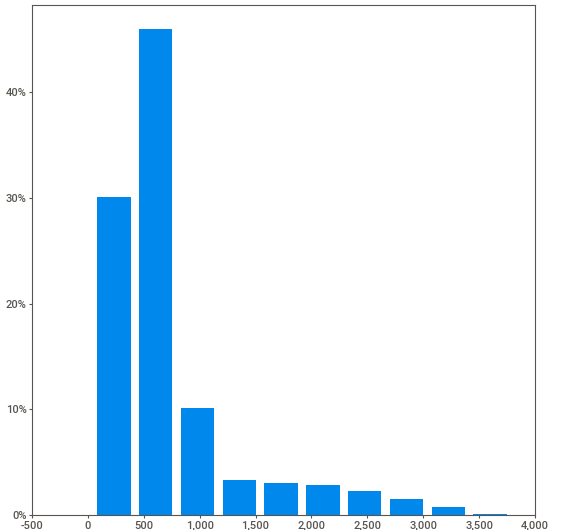
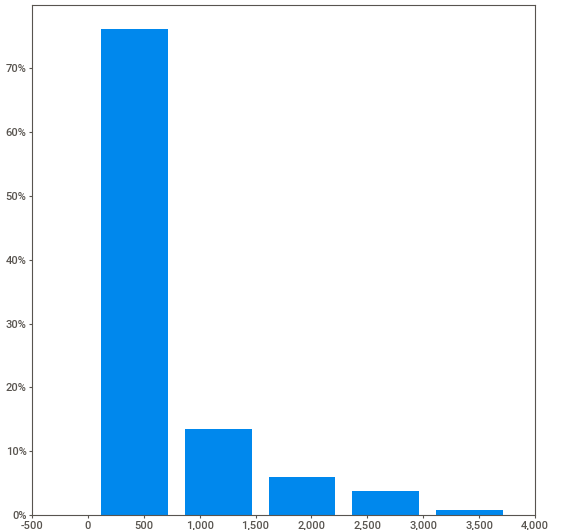
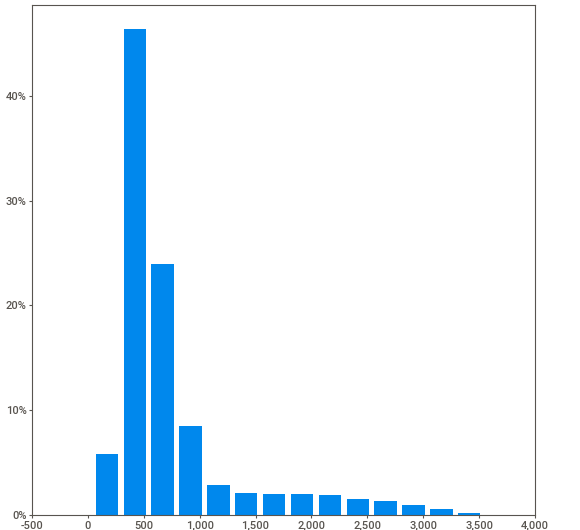
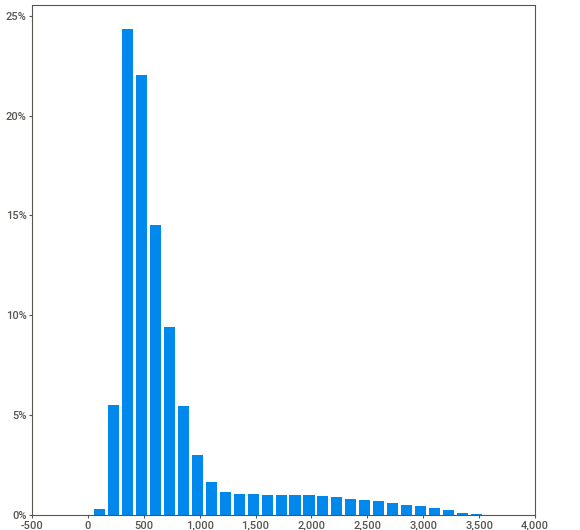
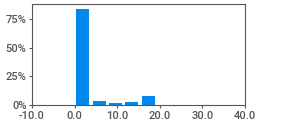
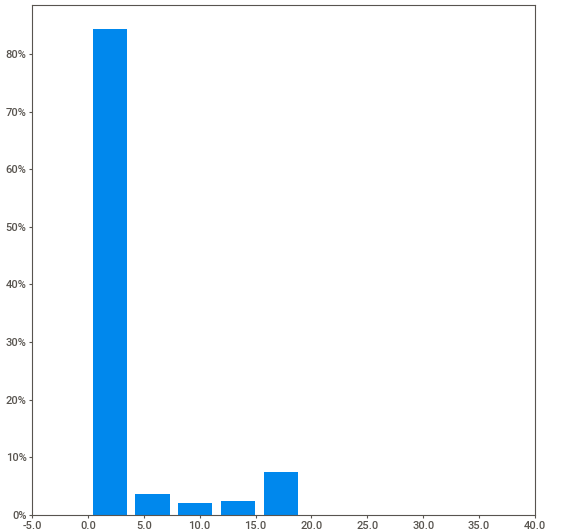
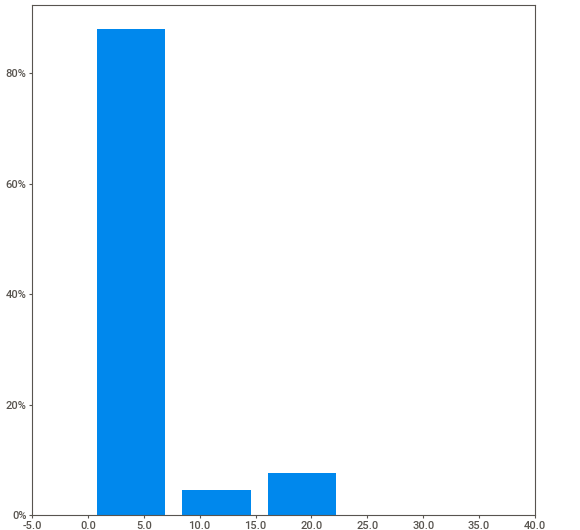
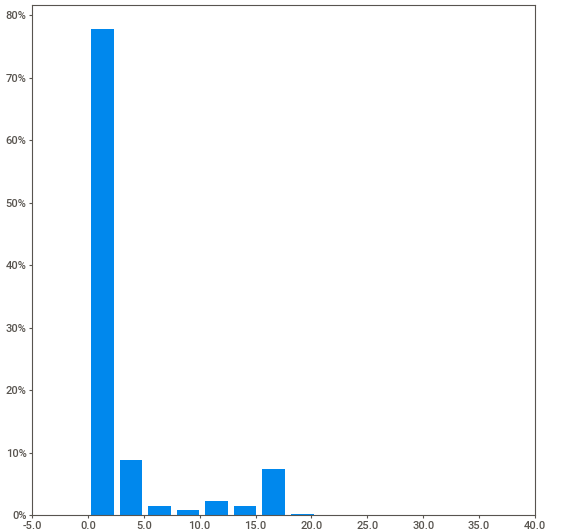
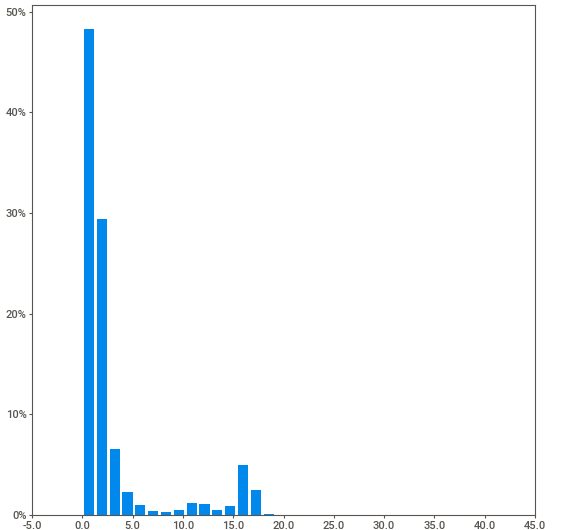
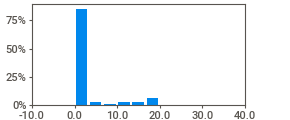
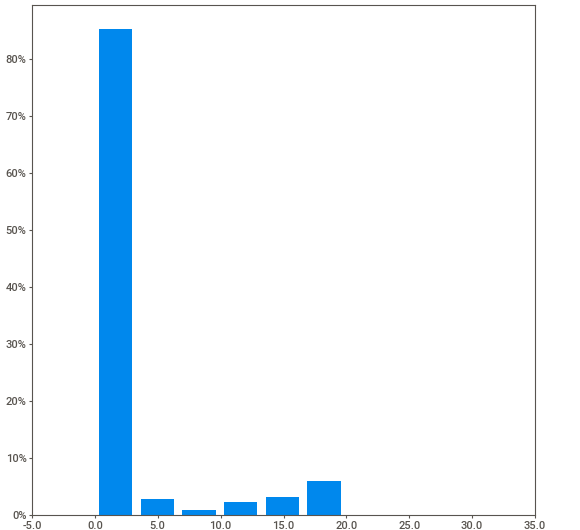
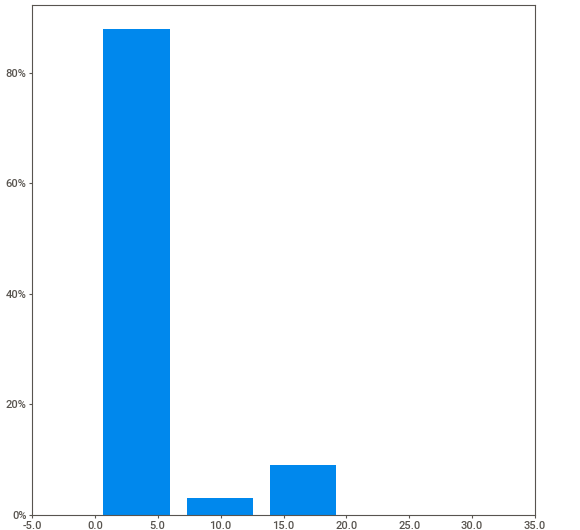
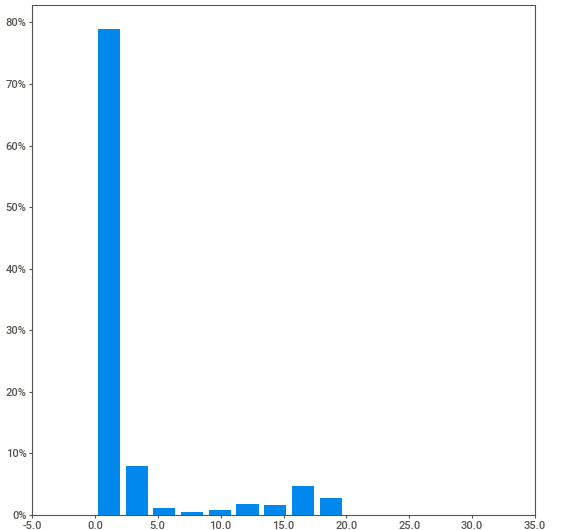
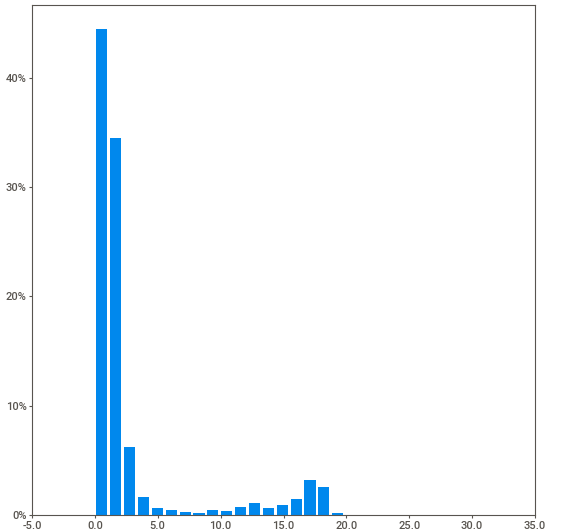
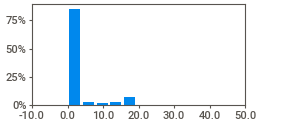
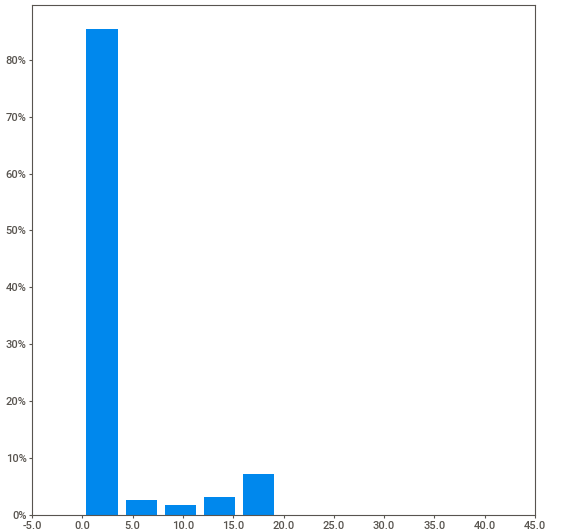
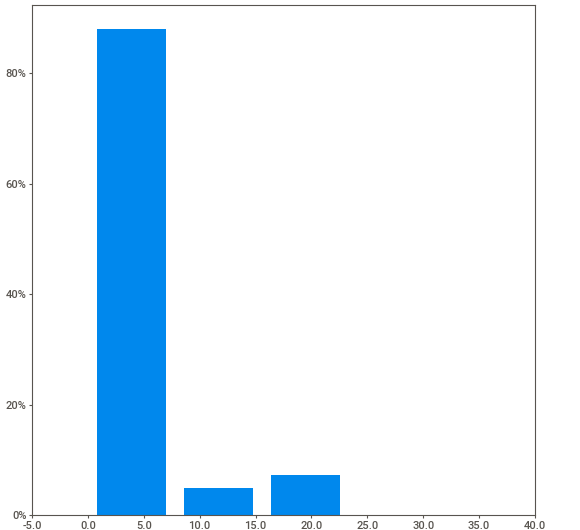
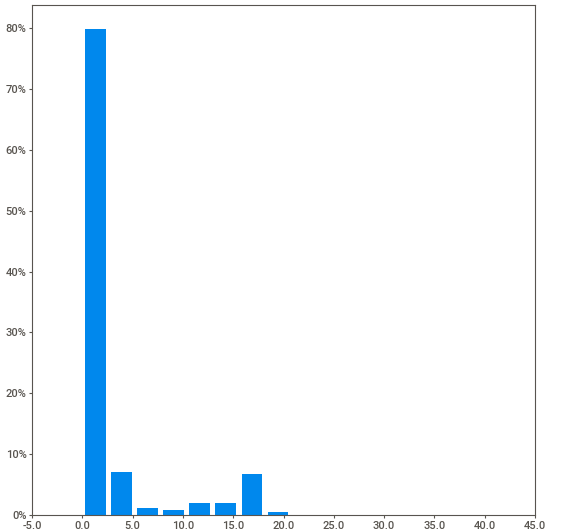
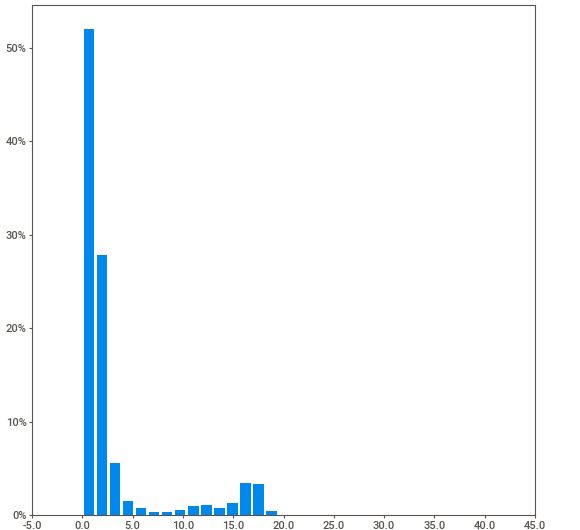
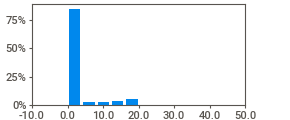
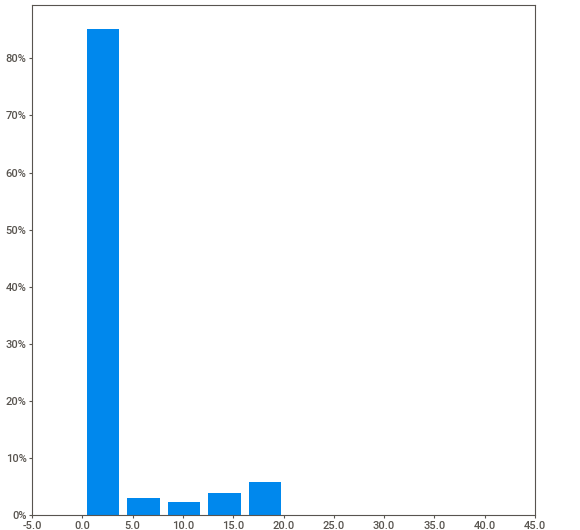
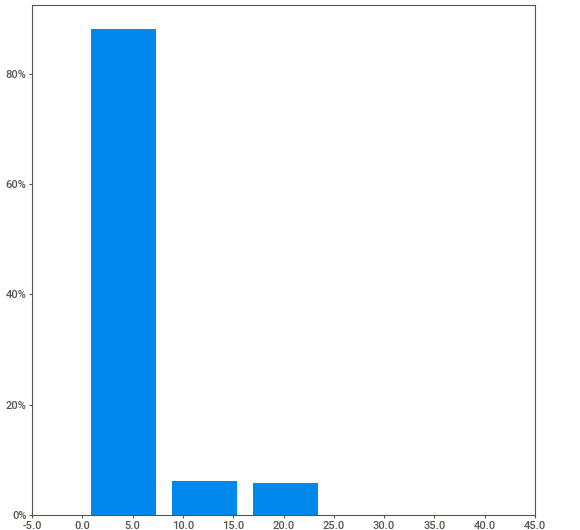
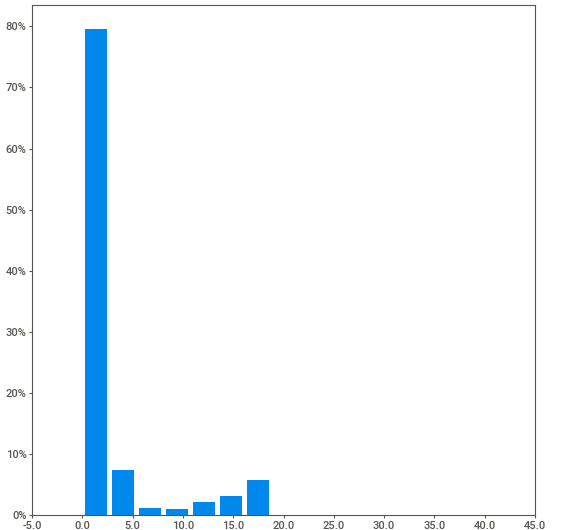
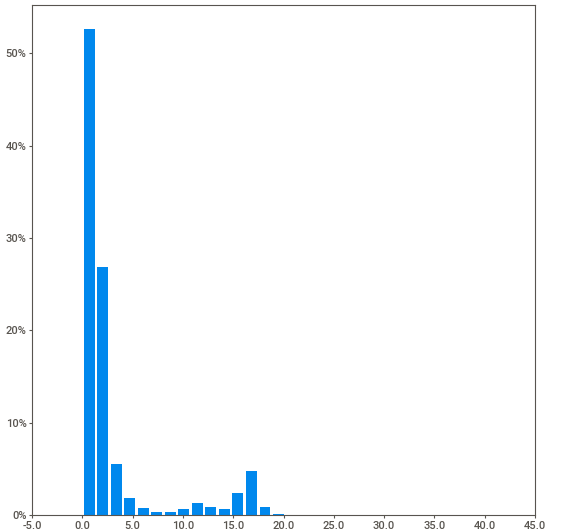
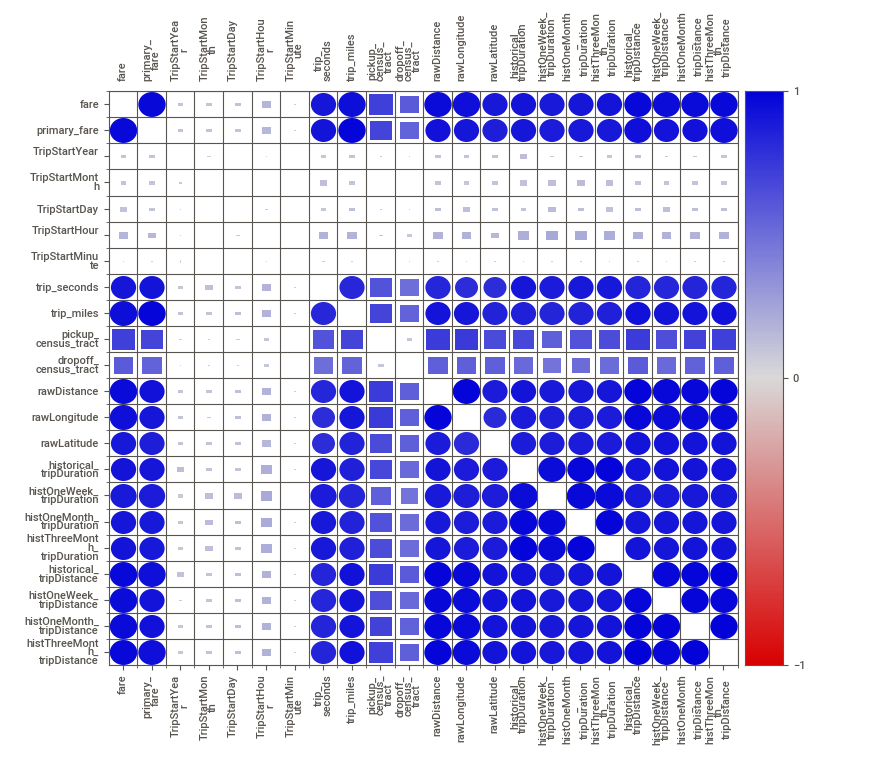
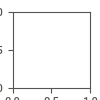

In [7]:
import sweetviz as sv

my_report = sv.analyze(data)
my_report.show_notebook()

## Feature selection

These are some good news that we have a lot of engineered features highly correlating with `trip_miles`, `trip_seconds` or even `fare` since:
- `fare` is the target variable to predict and finding high correlations between potential features known at serving time & the target variable is definitely promising;
- from documentation, `trip_miles` & `trip_seconds` are the most important factors determining the fare price; however such variables are not known at serving time - so we cannot use them for prediction. Then the features - known at serving time - which highly correlate with `trip_miles` & `trip_seconds` can definitely be used as subtitutes for prediction.

Based on those remarks, let's choose the features for modelling:
- `TripStartYear`, `TripStartMonth`, `TripStartDay`, `TripStartHour` & `TripStartMinute` will be categorical features referring to the trip start time;
- `pickup_census_tract` & `dropoff_census_tract` will be categorical features referring to the trip start & end locations;
- `historical_tripDuration` & `histOneWeek_tripDuration` are numerical features chosen to be substitutes to `trip_seconds` (remind that such features are engineered based on the same trip start/end locations & trip time - day & hour) - `historical_tripDuration`is a long snapshot of any external factors' impact on the trip duration while `histOneWeek_tripDuration` may encapsulate recent new external factors' impact;
- `historical_tripDistance` & `histOneWeek_tripDistance` are numerical features chosen to be substitutes to `trip_miles` (remind that such features are engineered based on the same trip start/end locations & trip time - day & hour) - `historical_tripDistance` is a long snapshot of any external factors' impact on the trip distance while `histOneWeek_tripDistance` may encapsulate recent new external factors' impact;
- `rawDistance` is a numerical feature referring to the euclidean distance between the trip start & end locations.